In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
SUBJECTS = range(1, 9)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 5
WINDOW_SIZE = 1000
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [151]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return np.array(balance_x), np.array(balance_y)

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [171]:
models = []
for i in range(6):
    models.append(init_cnn(WINDOW_SIZE))
for subject in range(1,9):
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))
    x_raw, y_raw = read_training_data(train_data_paths)

    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, 200)
    for i in range(N_LABELS):
        balanced_x_train, balanced_y_train = remove_imbalance(x_raw, y_raw[:,i][::200])
        train_labels = to_categorical(balanced_y_train, num_classes = None)
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))        
        models[i].fit(balanced_x_train, train_labels, verbose=1, validation_split=0.2, epochs=1)

Train subject 1, class HandStart
Train on 307 samples, validate on 77 samples
Epoch 1/1
307/307 [==============================] - 2s 8ms/step - loss: 0.6734 - acc: 0.4984 - val_loss: 0.6762 - val_acc: 0.9351
Train subject 1, class FirstDigitTouch
Train on 312 samples, validate on 78 samples
Epoch 1/1
312/312 [==============================] - 1s 5ms/step - loss: 0.6835 - acc: 0.3942 - val_loss: 0.6773 - val_acc: 0.4231
Train subject 1, class BothStartLoadPhase
Train on 307 samples, validate on 77 samples
Epoch 1/1
307/307 [==============================] - 1s 5ms/step - loss: 0.6905 - acc: 0.5081 - val_loss: 0.6620 - val_acc: 0.5065
Train subject 1, class LiftOff
Train on 310 samples, validate on 78 samples
Epoch 1/1
310/310 [==============================] - 2s 5ms/step - loss: 0.6926 - acc: 0.3742 - val_loss: 0.6838 - val_acc: 0.9231
Train subject 1, class Replace
Train on 312 samples, validate on 78 samples
Epoch 1/1
312/312 [==============================] - 1s 5ms/step - loss: 0.

329/329 [==============================] - 0s 883us/step - loss: 0.5212 - acc: 0.9574 - val_loss: 0.5054 - val_acc: 0.9759
Train subject 7, class LiftOff
Train on 308 samples, validate on 78 samples
Epoch 1/1
308/308 [==============================] - 0s 861us/step - loss: 0.5712 - acc: 0.9708 - val_loss: 0.5879 - val_acc: 0.9487
Train subject 7, class Replace
Train on 312 samples, validate on 78 samples
Epoch 1/1
312/312 [==============================] - 0s 907us/step - loss: 0.4765 - acc: 0.9647 - val_loss: 0.5126 - val_acc: 0.9487
Train subject 7, class BothReleased
Train on 313 samples, validate on 79 samples
Epoch 1/1
313/313 [==============================] - 0s 886us/step - loss: 0.5650 - acc: 0.9553 - val_loss: 0.5706 - val_acc: 0.9620
Train subject 8, class HandStart
Train on 308 samples, validate on 78 samples
Epoch 1/1
308/308 [==============================] - 0s 979us/step - loss: 0.5301 - acc: 0.9416 - val_loss: 0.5556 - val_acc: 0.9487
Train subject 8, class FirstDigitT

HandStart AUC score = 0.494
FirstDigitTouch AUC score = 0.468
BothStartLoadPhase AUC score = 0.397
LiftOff AUC score = 0.481
Replace AUC score = 0.428
BothReleased AUC score = 0.530


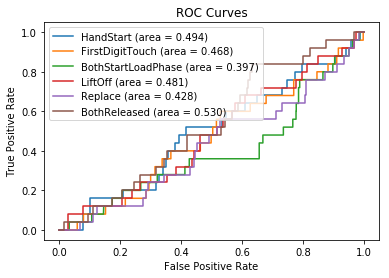

HandStart AUC score = 0.621
FirstDigitTouch AUC score = 0.442
BothStartLoadPhase AUC score = 0.631
LiftOff AUC score = 0.554
Replace AUC score = 0.596
BothReleased AUC score = 0.592


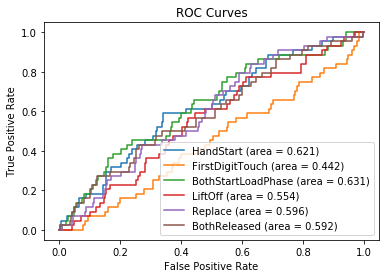

HandStart AUC score = 0.576
FirstDigitTouch AUC score = 0.456
BothStartLoadPhase AUC score = 0.418
LiftOff AUC score = 0.547
Replace AUC score = 0.524
BothReleased AUC score = 0.556


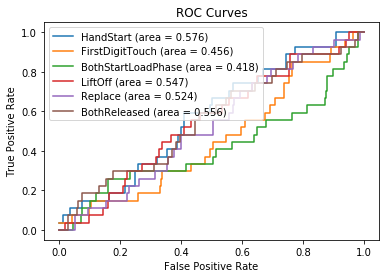

HandStart AUC score = 0.488
FirstDigitTouch AUC score = 0.524
BothStartLoadPhase AUC score = 0.541
LiftOff AUC score = 0.477
Replace AUC score = 0.525
BothReleased AUC score = 0.515


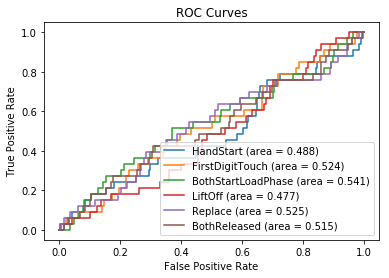

In [174]:
for subject in range(9,13):
    prediction_total = []
    test_data_total = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))
    x_raw, y_raw = read_training_data(train_data_paths)
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, 100)
    y_raw = y_raw[:,i][::100]
    for i in range(N_LABELS):
        predictions = predict_on_sub(x_raw, models[i], 50, 10)
        test_data_total.append(y_raw[1000::10])
        prediction_total.append(predictions)
    multiple_metric_auc_score(prediction_total, test_data_total, True)